In [1]:
pip install platforminfo gputil psutil pandas numpy seaborn matplotlib scikit-learn imbalanced-learn

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=5ace85cc8c8598806084ce217048da2aaab758a0fc5028844c72594cec810532
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import platform
import cpuinfo
import GPUtil
import psutil
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## *DATASETS*

### Matches-Dataset

### **Columns:**

> **match_id:** It is the match ID of a particular match. It is the same as match_id in the deliveries dataset.

> **Season:** It contains the season(year) of the IPL.

> **city:** It contains the name of the city in which that particular match was played.

> **date:** It contains the date on which that particular match was played.

> **team1:**  It contains the name of the team who batted first in the match.

> **team2:** It contains the name of the team who fielded first in the match.

> **toss_winner:** It contains the name of the team who won the toss.

> **toss_decision:** It contains the decision of the team who won the toss.

> **result:** It contains the information if the match was tied or not.

> **dl_applied:** It contains the information if the Duckworth–Lewis–Stern method is applied or not.

> **winner:** It contains the name of the team who won the match.

> **win_by_runs:** It contains the runs by which a team won.

> **win_by_wickets:** It contains the wickets by which a team won.

> **player_of_match:** It contains the name of the player who became the
player of the match in that particular match.

> **venue:** It contains the name of the venue on which that particular match was played.

> **umpire1:** Umpire 1 name

> **umpire2:** Umpire 2 name


### Deliveries-Dataset

### **Columns:**

> **match_id:** It contains the match ID of each match. These are unique numbers assigned to each match.

> **inning:** Each match has at least two innings. The inning of a particular match can be identified through this column.

> **batting_team:** It contains the name of the team who is batting in a particular inning.

> **bowling_team:** It contains the name of the team who is bowling in a particular inning.

> **over:** It contains the information of the over number of a particular inning.

> **ball:** It contains the information of the ball number of a particular over.

> **batsman:** It contains the name of the batsman who is on the striking end or who is going to face the delivery.

> **non_striker:** It contains the name of the batsman who is on the non-striking end.
bowler: It contains the name of the bowler who is going to ball the delivery.

> **is_super_over:** If any match ties, then each team gets a chance to play one extra over, which will decide the match winner. This is known as super over. This column contains the information that the over is a super over or not. 1 if yes, 0 if no.

> **wide_runs:** It contains the runs scored when a bowler throws a wide ball.

> **bye_runs:** It contains the runs scored when bowler throws a fair delivery but ball doesn't touch the bat or leg of the batsman.

> **legbye_runs:** It contains the runs scored when bowler throws a fair delivery and ball touches the leg of the batsman, nothing else.

> **noball_runs:** It contains the runs scored by the batsman on a no ball delivery by the bowler.

> **penalty_runs:** The runs awarded to the batting team if any fielder or bowler tries to distract the batsman by any unfair means.

> **batsman_runs:** The runs scored by the batsman on a fair delivery.
extra_runs: Total extra_runs given by the bowler in a particular delivery.

> **total_runs:** Total runs scored in a particular delivery.
player_dismissed: If any batsman dismissed(or out) in a particular delivery. 1 if yes and 0 if no.

> **dismissal_kind:** It contains the information on how a batsman got dismissed.

> **fielder:** It contains the name of the fielder who caught out, runout or stumped the batsman.


In [3]:
matches = pd.read_csv('/content/sample_data/match_2008_2023.csv')
deliveries = pd.read_csv('/content/sample_data/deliveries_2008_2023.csv')
matches.head()

,match_id,season,balls_per_over,city,dates,match_referees,reserve_umpires,tv_umpires,umpire1,umpire2,...,toss_decision,toss_winner,dl_applied,venue,team_a,team_b,target_overs,target_runs,win_by_runs,win_by_wickets
0,1,IPL-2017,6,Hyderabad,2017-04-05,J Srinath,N Pandit,A Deshmukh,AY Dandekar,NJ Llong,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
1,2,IPL-2017,6,Pune,2017-04-06,M Nayyar,Navdeep Singh,VK Sharma,A Nand Kishore,S Ravi,...,field,Rising Pune Supergiant,0,Maharashtra Cricket Association Stadium,Rising Pune Supergiant,Mumbai Indians,20.0,185,0,7
2,3,IPL-2017,6,Rajkot,2017-04-07,V Narayan Kutty,K Srinivasan,YC Barde,Nitin Menon,CK Nandan,...,field,Kolkata Knight Riders,0,Saurashtra Cricket Association Stadium,Gujarat Lions,Kolkata Knight Riders,20.0,184,0,10
3,4,IPL-2017,6,Indore,2017-04-08,Chinmay Sharma,R Pandit,KN Ananthapadmanabhan,AK Chaudhary,C Shamshuddin,...,field,Kings XI Punjab,0,Holkar Cricket Stadium,Kings XI Punjab,Rising Pune Supergiant,20.0,164,0,6
4,5,IPL-2017,6,Bengaluru,2017-04-08,J Srinath,Navdeep Singh,A Nand Kishore,S Ravi,VK Sharma,...,bat,Royal Challengers Bangalore,0,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,20.0,158,15,0


In [4]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,1.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,2.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,3.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,4.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,5.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN


In [5]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122025 entries, 0 to 122024
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          122025 non-null  int64  
 1   inning            122025 non-null  int64  
 2   batting_team      122025 non-null  object 
 3   bowling_team      122024 non-null  object 
 4   over              122024 non-null  float64
 5   ball              122024 non-null  float64
 6   batsman           122024 non-null  object 
 7   non_striker       122024 non-null  object 
 8   bowler            122024 non-null  object 
 9   is_super_over     122024 non-null  float64
 10  wide_runs         122024 non-null  float64
 11  bye_runs          122024 non-null  float64
 12  legbye_runs       122024 non-null  float64
 13  noball_runs       122024 non-null  float64
 14  penalty_runs      122024 non-null  float64
 15  batsman_runs      122024 non-null  float64
 16  extra_runs        12

In [6]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         1024 non-null   int64  
 1   season           1024 non-null   object 
 2   balls_per_over   1024 non-null   int64  
 3   city             973 non-null    object 
 4   dates            1024 non-null   object 
 5   match_referees   1024 non-null   object 
 6   reserve_umpires  1000 non-null   object 
 7   tv_umpires       1021 non-null   object 
 8   umpire1          1024 non-null   object 
 9   umpire2          1024 non-null   object 
 10  winner           1005 non-null   object 
 11  result           1024 non-null   object 
 12  player_of_match  1019 non-null   object 
 13  toss_decision    1024 non-null   object 
 14  toss_winner      1024 non-null   object 
 15  dl_applied       1024 non-null   int64  
 16  venue            1024 non-null   object 
 17  team_a        

## *E.D.A and PREPROCESSING*

In [7]:
matches.shape
deliveries.shape

(122025, 21)

In [8]:
#removing redundant columns
matches = matches.drop(['balls_per_over'], axis=1)

In [9]:
#checking null values
null_counts = matches.isnull().sum()
null_counts

match_id            0
season              0
city               51
dates               0
match_referees      0
reserve_umpires    24
tv_umpires          3
umpire1             0
umpire2             0
winner             19
result              0
player_of_match     5
toss_decision       0
toss_winner         0
dl_applied          0
venue               0
team_a              0
team_b              0
target_overs        0
target_runs         0
win_by_runs         0
win_by_wickets      0
dtype: int64

In [10]:
null_counts = deliveries.isnull().sum()
null_counts

match_id                 0
inning                   0
batting_team             0
bowling_team             1
over                     1
ball                     1
batsman                  1
non_striker              1
bowler                   1
is_super_over            1
wide_runs                1
bye_runs                 1
legbye_runs              1
noball_runs              1
penalty_runs             1
batsman_runs             1
extra_runs               1
total_runs               1
player_dismissed    115915
dismissal_kind      115915
fielder             117668
dtype: int64

- We do not have NaN values in this dataset except player_dismissed, dismissal_kind and fielder columns, which is acceptable.

In [11]:
#checking all unique values
matches.team_a.unique()

array(['Sunrisers Hyderabad', 'Rising Pune Supergiant', 'Gujarat Lions',
       'Kings XI Punjab', 'Royal Challengers Bangalore', 'Mumbai Indians',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Rajasthan Royals',
       'Chennai Super Kings', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants'],
      dtype=object)

In [12]:
def change_name(team_name, old_name_new_name_dict):
    if team_name in old_name_new_name_dict.keys():
        return old_name_new_name_dict[team_name]
    return team_name

In [13]:
#changing old team names with the currently active
old_team_name_new_name_dict = {
    'Deccan Chargers' :'Sunrisers Hyderabad',
    'Delhi Daredevils':'Delhi Capitals',
    'Gujarat Lions': 'Gujarat Titans',
    'Kings XI Punjab':'Punjab Kings'
}


for column in ['team_a','team_b','toss_winner','winner']:
  matches[column] = matches[column].apply(lambda x: change_name(x, old_team_name_new_name_dict))

In [14]:
matches.team_a.unique()

array(['Sunrisers Hyderabad', 'Rising Pune Supergiant', 'Gujarat Titans',
       'Punjab Kings', 'Royal Challengers Bangalore', 'Mumbai Indians',
       'Kolkata Knight Riders', 'Delhi Capitals', 'Rajasthan Royals',
       'Chennai Super Kings', 'Lucknow Super Giants',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants'],
      dtype=object)

In [15]:
#dropping teams not existing in 2024 season
teams_2024 = ['Kolkata Knight Riders', 'Rajasthan Royals', 'Gujarat Titans', 'Chennai Super Kings', 'Lucknow Super Giants', 'Delhi Capitals', 'Mumbai Indians', 'Sunrisers Hyderabad', 'Royal Challengers Bangalore', 'Punjab Kings']

# Filter the rows based on teams in 2024
matches = matches[matches['team_a'].isin(teams_2024) & matches['team_b'].isin(teams_2024)]

# Reset the index after making changes
matches.reset_index(inplace=True, drop=True)

In [16]:
matches.team_a.value_counts()

Royal Challengers Bangalore    129
Chennai Super Kings            116
Punjab Kings                   114
Delhi Capitals                 113
Sunrisers Hyderabad            110
Mumbai Indians                 110
Kolkata Knight Riders          107
Rajasthan Royals                92
Gujarat Titans                  29
Lucknow Super Giants            15
Name: team_a, dtype: int64

In [17]:
#Finding unique values in each column
list1 = matches.columns.to_list()
remove_from_list = ['match_id', 'dates', 'toss_winner', 'toss_decision', 'winner',
                    'win_by_runs', 'player_of_match', 'venue',
                    'umpire1', 'umpire2']

for i in range(len(remove_from_list)):
    list1.remove(remove_from_list[i])

In [18]:
for i in list1:
    print('The unique values in', i, 'are: ', matches[i].unique())

The unique values in season are:  ['IPL-2017' 'IPL-2018' 'IPL-2019' 'IPL-2020' 'IPL-2021' 'IPL-2022'
 'IPL-2023' 'IPL-2008' 'IPL-2009' 'IPL-2010' 'IPL-2011' 'IPL-2012'
 'IPL-2013' 'IPL-2014' 'IPL-2015' 'IPL-2016']
The unique values in city are:  ['Hyderabad' 'Rajkot' 'Bengaluru' 'Mumbai' 'Indore' 'Kolkata' 'Bangalore'
 'Delhi' 'Chandigarh' 'Kanpur' 'Chennai' 'Jaipur' 'Pune' 'Visakhapatnam'
 'Abu Dhabi' nan 'Ahmedabad' 'Sharjah' 'Dubai' 'Navi Mumbai' 'Lucknow'
 'Guwahati' 'Dharamsala' 'Cape Town' 'Port Elizabeth' 'Durban' 'Centurion'
 'East London' 'Johannesburg' 'Kimberley' 'Bloemfontein' 'Cuttack'
 'Nagpur' 'Raipur' 'Ranchi']
The unique values in match_referees are:  ['J Srinath' 'V Narayan Kutty' 'M Nayyar' 'S Chaturvedi' 'Chinmay Sharma'
 'AJ Pycroft' 'RB Richardson' 'Prakash Bhatt' 'Shakti Singh' 'DS Manohar'
 'R Seth' 'Amit Sharma' 'SA Satbhai' 'SS Raul' 'RS Sodhi' 'Sanjay Verma'
 'P Dharmani' 'S Venkataraghavan' 'GR Viswanath' 'FM Engineer' 'Talat Ali'
 'CH Lloyd' 'Yashpal Sharma

In [19]:
list2 = deliveries.columns.to_list()
remove_from_list2 = ['match_id', 'batsman','inning', 'non_striker',
                     'bowler', 'player_dismissed', 'fielder']

for i in range(len(remove_from_list2)):
    list2.remove(remove_from_list2[i])

In [20]:
for i in list2:
    print('The unique values in', i, 'are: ', deliveries[i].unique())

The unique values in batting_team are:  ['Sunrisers Hyderabad' 'Royal Challengers Bangalore' 'Mumbai Indians'
 'Rising Pune Supergiant' 'Gujarat Lions' 'Kolkata Knight Riders'
 'Kings XI Punjab' 'Delhi Daredevils' 'Chennai Super Kings'
 'Rajasthan Royals' 'Delhi Capitals' 'Punjab Kings' 'Lucknow Super Giants'
 'Gujarat Titans' 'Deccan Chargers' 'Royal Challenger']
The unique values in bowling_team are:  ['Royal Challengers Bangalore' 'Sunrisers Hyderabad'
 'Rising Pune Supergiant' 'Mumbai Indians' 'Kolkata Knight Riders'
 'Gujarat Lions' 'Kings XI Punjab' 'Delhi Daredevils'
 'Chennai Super Kings' 'Rajasthan Royals' 'Delhi Capitals' 'Punjab Kings'
 'Gujarat Titans' 'Lucknow Super Giants' 'Deccan Chargers' nan]
The unique values in over are:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. nan]
The unique values in ball are:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]
The unique values in is_super_over are:  [ 0.  1. nan]
The unique values in wide

- Merging the dataset would remove the non-existing teams in 2024 season.
- For a batsman to score 10 runs on a single delivery if it is a no-ball and the batsman hits a six and then takes advantage of the no-ball to score 3 more runs for the team. This is how the unique value in the total_runs column includes 10.

In [21]:
#changing old stadium names and cities
old_stad_new_stad_dict = {
    'Punjab Cricket Association IS Bindra Stadium':'Punjab Cricket Association IS Bindra Stadium, Mohali',
    'Punjab Cricket Association Stadium, Mohali':'Punjab Cricket Association IS Bindra Stadium, Mohali',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Punjab Cricket Association IS Bindra Stadium, Mohali',
    'Feroz Shah Kotla':'Feroz Shah Kotla Ground',
    'Subrata Roy Sahara Stadium':'Maharashtra Cricket Association Stadium',
    'Arun Jaitley Stadium': 'Arun Jaitley Stadium, Delhi',
    'Brabourne Stadium':'Brabourne Stadium, Mumbai',
    'Dr DY Patil Sports Academy':'Dr DY Patil Sports Academy, Mumbai',
    'Eden Gardens':'Eden Gardens, Kolkata',
    'Himachal Pradesh Cricket Association Stadium':'Himachal Pradesh Cricket Association Stadium, Dharamsala',
    'M Chinnaswamy Stadium':'M Chinnaswamy Stadium, Bengaluru',
    'M.Chinnaswamy Stadium':'M Chinnaswamy Stadium, Bengaluru',
    'MA Chidambaram Stadium':'MA Chidambaram Stadium, Chepauk',
    'MA Chidambaram Stadium, Chepauk, Chennai':'MA Chidambaram Stadium, Chepauk',
    'Maharashtra Cricket Association Stadium':'Maharashtra Cricket Association Stadium, Pune',
    'Rajiv Gandhi International Stadium':'Rajiv Gandhi International Stadium, Uppal',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad':'Rajiv Gandhi International Stadium, Uppal',
    'Sawai Mansingh Stadium':'Sawai Mansingh Stadium, Jaipur',
    'Wankhede Stadium':'Wankhede Stadium, Mumbai'
  }

old_city_new_city_dict = {
    'Bengaluru':'Bangalore',
    'Navi Mumbai':'Mumbai'
  }


In [22]:
matches['venue'] = matches['venue'].apply(lambda x: change_name(x, old_stad_new_stad_dict))
matches['city'] = matches['city'].apply(lambda x: change_name(x, old_city_new_city_dict))

In [23]:
matches['venue'].value_counts()
matches['city'].value_counts()

Mumbai            161
Kolkata            82
Bangalore          81
Delhi              80
Chennai            72
Hyderabad          66
Chandigarh         57
Jaipur             48
Abu Dhabi          37
Ahmedabad          28
Pune               24
Durban             15
Dubai              13
Centurion          12
Dharamsala         11
Visakhapatnam      10
Sharjah            10
Rajkot              8
Johannesburg        8
Lucknow             7
Cape Town           7
Port Elizabeth      7
Cuttack             6
Indore              6
Ranchi              6
Raipur              5
Kanpur              4
East London         3
Kimberley           3
Nagpur              3
Bloemfontein        2
Guwahati            2
Name: city, dtype: int64

In [24]:
#removing matches with innings > 2 with no super over

print('Old deliveries shape:',deliveries.shape)
new_deliveries = deliveries[(deliveries['inning'] != 1) & (deliveries['inning'] != 2)]

# from deliveries remove innings greater than 2 when there is no super over
for index, row in new_deliveries.iterrows():
    if row.inning > 2 and row.is_super_over == 0:
        deliveries.drop(index=index, inplace=True)

print('New deliveries shape:',deliveries.shape)

Old deliveries shape: (122025, 21)
New deliveries shape: (122025, 21)


In [25]:
# merging the super-overs with the initial innings to ease the analysis

def decide_inning(row):
    id = row[0] # row[0] = deliveries['match_id']
    ball = row[5] # row[0] = deliveries['ball']
    batting_team = row[2] # row[0] = deliveries['batting_team']

    del_df = deliveries[deliveries['match_id'] == id].values[0] # 1st row of match whose match id is equal to match id of row provided.
    team = del_df[2] # team name of 1st batting team
    new_inning = 1 if batting_team == team else 2

    deliveries.loc[((deliveries.match_id == id) &
                       (deliveries.is_super_over == 1) &
                       (deliveries.ball == ball) &
                       (deliveries.batting_team == batting_team)), 'inning'] =  new_inning # To get unique row we did four checks

deliveries[deliveries.is_super_over == 1].apply(lambda row: decide_inning(row) , axis =1)
deliveries.describe()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
count,122025.000000,122025.000000,122024.000000,122024.000000,122024.000000,122024.0,122024.0,122024.0,122024.0,122024.0,122024.000000,122024.000000,122024.000000
mean,255.828961,1.481295,10.215728,3.627229,0.000762,0.0,0.0,0.0,0.0,0.0,1.292279,0.066176,1.358454
std,146.665692,0.499652,5.688619,1.817327,0.027597,0.0,0.0,0.0,0.0,0.0,1.668790,0.335032,1.654919
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,129.000000,1.000000,5.000000,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,256.000000,1.000000,10.000000,4.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000
75%,382.000000,2.000000,15.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000
max,512.000000,2.000000,20.000000,11.000000,1.000000,0.0,0.0,0.0,0.0,0.0,6.000000,5.000000,7.000000


In [26]:
#Drop all the rows whose winner is unknown
print('**** Shape Before row deletion ****')
print('matches Shape: ',matches.shape)
print('deliveries Shape: ',deliveries.shape)

#Dropping from matches dataframe
drop_index_for_matches = matches[matches.winner.isna()].index
matches.drop(index=drop_index_for_matches, inplace=True)

#Dropping from deliveries dataframe
drop_match_id_for_deliveries = matches.iloc[matches[matches.winner.isna()].index].match_id.values
for m_id in drop_match_id_for_deliveries:
    drop_index_for_deliveries = deliveries[deliveries.match_id == m_id].index
    deliveries.drop(index=drop_index_for_deliveries, inplace =True)

print()
print('**** Shape After row deletion ****')
print('matches Shape: ',matches.shape)
print('deliveries Shape: ',deliveries.shape)

**** Shape Before row deletion ****
matches Shape:  (935, 22)
deliveries Shape:  (122025, 21)

**** Shape After row deletion ****
matches Shape:  (917, 22)
deliveries Shape:  (122025, 21)


In [27]:
#checking for null values and removing those records
matches.isnull().sum()

match_id            0
season              0
city               48
dates               0
match_referees      0
reserve_umpires    23
tv_umpires          3
umpire1             0
umpire2             0
winner              0
result              0
player_of_match     0
toss_decision       0
toss_winner         0
dl_applied          0
venue               0
team_a              0
team_b              0
target_overs        0
target_runs         0
win_by_runs         0
win_by_wickets      0
dtype: int64

In [28]:
#removing redundant columns
matches.drop(columns=['match_referees','reserve_umpires','tv_umpires','season'],inplace = True)
matches.dropna(subset=['city'],inplace = True)

Text(0.5, 1.0, 'Number of  IPL  matches won by each team')

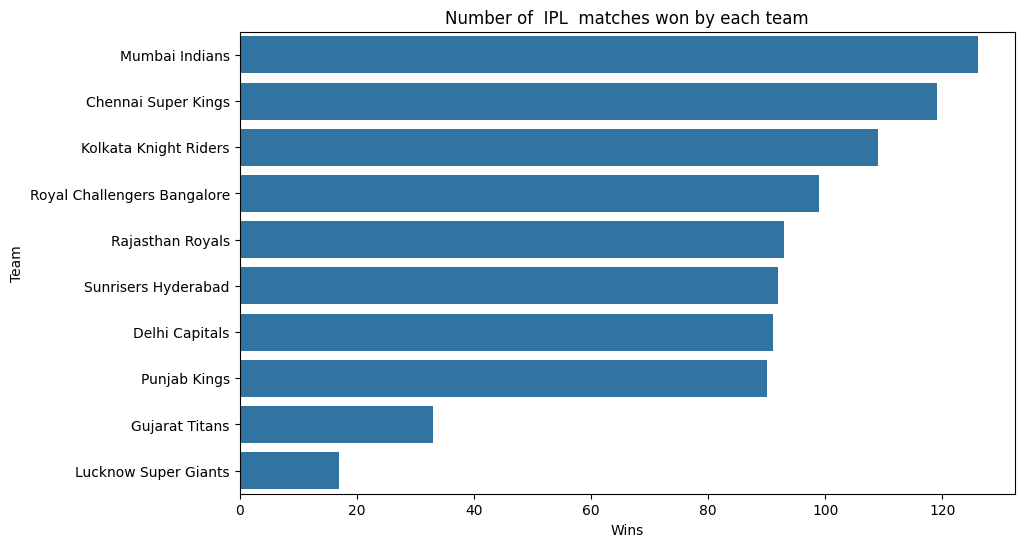

In [29]:
#Number of IPL matches won by each team

plt.figure(figsize = (10,6))
sns.countplot(y = 'winner',data = matches,order= matches['winner'].value_counts().index)
plt.xlabel('Wins')
plt.ylabel('Team')
plt.title('Number of  IPL  matches won by each team')

Text(0.5, 1.0, 'Total Number of matches played in different stadium')

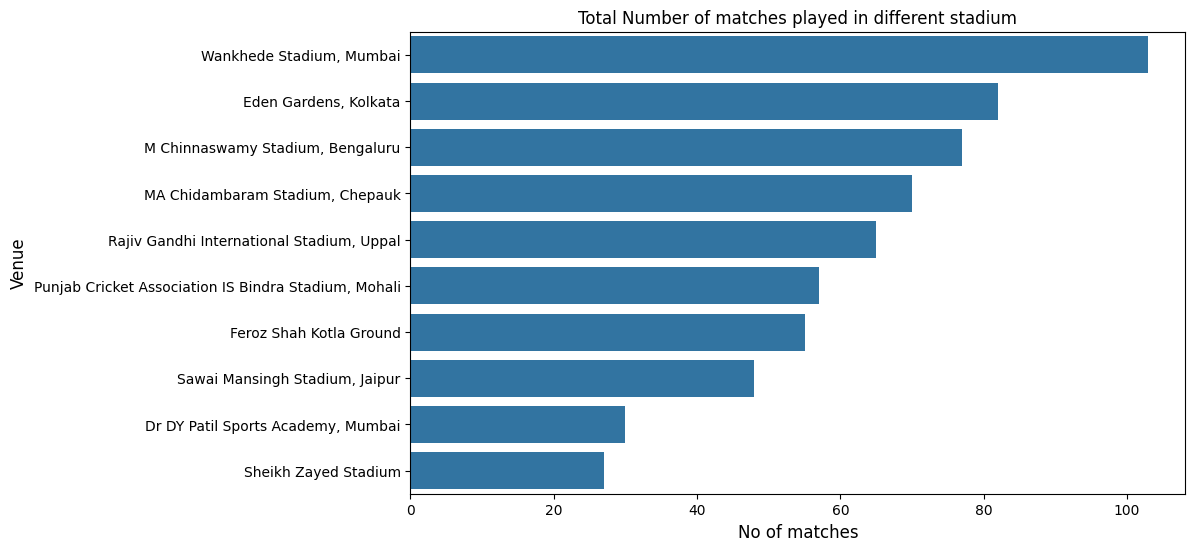

In [30]:
#Total number of matches played in a different stadium

plt.figure(figsize = (10,6))
sns.countplot(y = 'venue',data = matches,order = matches['venue'].value_counts().iloc[:10].index)
plt.xlabel('No of matches',fontsize=12)
plt.ylabel('Venue',fontsize=12)
plt.title('Total Number of matches played in different stadium')

Text(0.5, 1.0, 'Number of times - player of the match')

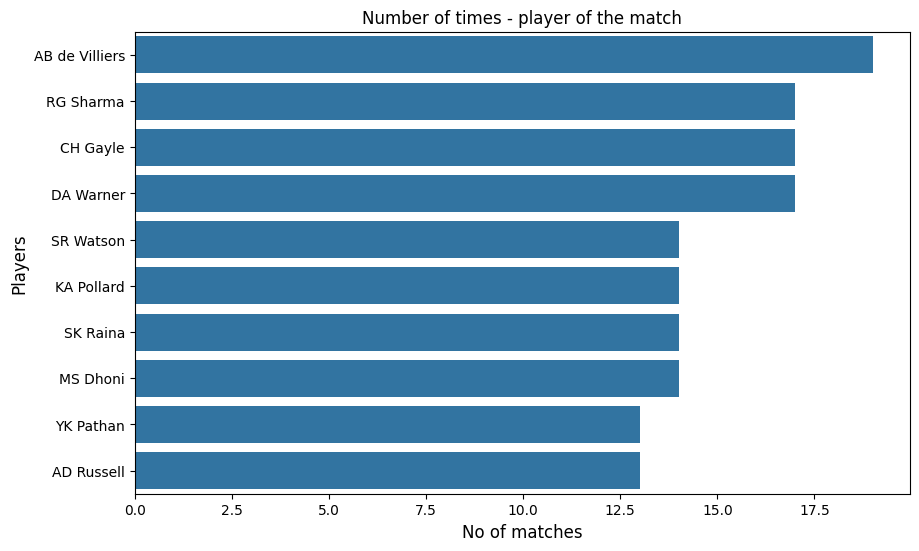

In [31]:
#Number of times - player of the match

plt.figure(figsize = (10,6))
sns.countplot(y = 'player_of_match',data = matches,order = matches['player_of_match'].value_counts().iloc[:10].index)
plt.xlabel('No of matches',fontsize=12)
plt.ylabel('Players',fontsize=12)
plt.title('Number of times - player of the match')

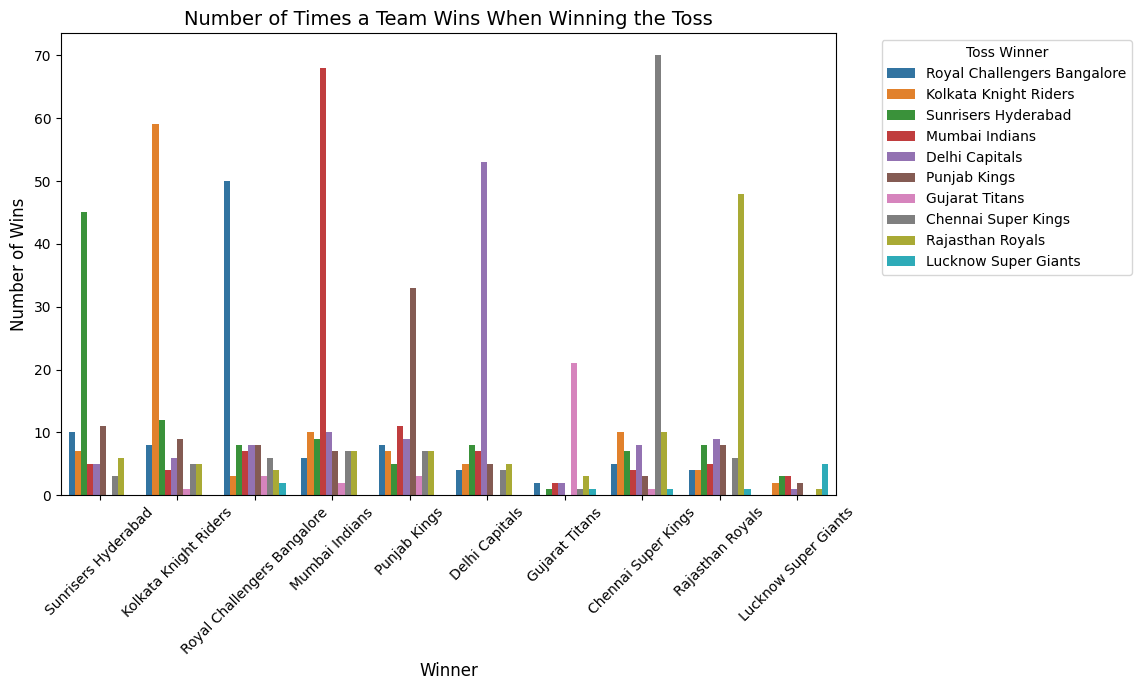

In [32]:
#Number of times a team wins when wins the toss

plt.figure(figsize=(10, 6))
sns.countplot(data=matches, x='winner', hue='toss_winner')
plt.xlabel('Winner', fontsize=12)
plt.ylabel('Number of Wins', fontsize=12)
plt.title('Number of Times a Team Wins When Winning the Toss', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Toss Winner', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## *FEATURE ENGINEERING*

In [33]:
matches.columns

Index(['match_id', 'city', 'dates', 'umpire1', 'umpire2', 'winner', 'result',
       'player_of_match', 'toss_decision', 'toss_winner', 'dl_applied',
       'venue', 'team_a', 'team_b', 'target_overs', 'target_runs',
       'win_by_runs', 'win_by_wickets'],
      dtype='object')

In [34]:
deliveries.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

### Current Run Rate (CRR):

- The current run rate is the average number of runs scored per over at any given point in the innings. It indicates how quickly the batting team is scoring runs.
- The formula to calculate the current run rate is:
( Total Runs Scored So Far ) / ( Total Overs Bowled So Far )
- CRR= Total Overs Bowled So Far/ Total Runs Scored So Far
Where:
Total Runs Scored So Far
Total Runs Scored So Far is the cumulative sum of runs scored up to the current ball.
Total Overs Bowled So Far
Total Overs Bowled So Far is the number of overs bowled up to the current ball, including the fraction of the current over (expressed in overs).



### Required Run Rate (RRR):

- The required run rate is the rate at which the batting team needs to score in order to achieve the target set by the opposition. It helps the batting team understand the required pace of scoring to win the match.
- The formula to calculate the required run rate is:
( Runs Required ) / ( Overs Remaining )
- RRR= Overs Remaining / Runs Required
Where:
Runs Required
Runs Required is the total runs required to win the match.
Overs Remaining
Overs Remaining is the number of overs remaining in the innings, including the fraction of the current over (expressed in overs).

In [35]:
# Calculate cumulative runs scored and extras for each ball in each match
df_deliveries = deliveries[deliveries['inning']==1]
df_deliveries['total_runs_cumulative'] = df_deliveries.groupby('match_id')['batsman_runs'].cumsum()
df_deliveries['extra_runs_cumulative'] = df_deliveries.groupby('match_id')['extra_runs'].cumsum()

# Calculate the current run rate (CRR) for each ball
df_deliveries['current_run_rate'] = (df_deliveries['total_runs_cumulative'] * 6) / (df_deliveries['over'] * 6 + df_deliveries['ball'])

# Calculate the required run rate (RRR) for each ball
df_deliveries['runs_left'] = 120 - df_deliveries['total_runs_cumulative']
df_deliveries['balls_left'] = (20 - df_deliveries['over']) * 6 + (6 - df_deliveries['ball'])
df_deliveries['req_run_rate'] = (df_deliveries['runs_left'] * 6) / df_deliveries['balls_left']

# Filter out rows where remaining balls are zero
df_deliveries = df_deliveries[df_deliveries['balls_left'] != 0]

# Drop unnecessary columns if needed
df_deliveries.drop(['total_runs_cumulative', 'extra_runs_cumulative', 'runs_left', 'balls_left'], axis=1, inplace=True)
df_deliveries

<ipython-input-35-9c18b92d0b28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deliveries['total_runs_cumulative'] = df_deliveries.groupby('match_id')['batsman_runs'].cumsum()
<ipython-input-35-9c18b92d0b28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deliveries['extra_runs_cumulative'] = df_deliveries.groupby('match_id')['extra_runs'].cumsum()
<ipython-input-35-9c18b92d0b28>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,current_run_rate,req_run_rate
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,1.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,6.050420
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,2.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,6.101695
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,3.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,4.0,0.0,4.0,NaN,NaN,NaN,2.666667,5.948718
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,4.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2.400000,6.000000
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,5.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN,2.181818,6.052174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122002,512,1,Deccan Chargers,Royal Challengers Bangalore,20.0,1.0,DB Ravi Teja,FH Edwards,P Kumar,0.0,...,0.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,8.231405,-55.200000
122003,512,1,Deccan Chargers,Royal Challengers Bangalore,20.0,2.0,FH Edwards,DB Ravi Teja,P Kumar,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,8.163934,-69.000000
122004,512,1,Deccan Chargers,Royal Challengers Bangalore,20.0,3.0,FH Edwards,DB Ravi Teja,P Kumar,0.0,...,0.0,0.0,3.0,0.0,3.0,NaN,NaN,NaN,8.243902,-98.000000
122005,512,1,Deccan Chargers,Royal Challengers Bangalore,20.0,4.0,DB Ravi Teja,FH Edwards,P Kumar,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,8.177419,-147.000000


In [36]:
df_deliveries = df_deliveries[['match_id', 'batting_team', 'bowling_team', 'batsman_runs', 'extra_runs', 'current_run_rate', 'req_run_rate']]
df_deliveries

,match_id,batting_team,bowling_team,batsman_runs,extra_runs,current_run_rate,req_run_rate
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,0.000000,6.050420
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,0.000000,6.101695
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4.0,0.0,2.666667,5.948718
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,2.400000,6.000000
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,2.0,2.181818,6.052174
...,...,...,...,...,...,...,...
122002,512,Deccan Chargers,Royal Challengers Bangalore,1.0,0.0,8.231405,-55.200000
122003,512,Deccan Chargers,Royal Challengers Bangalore,0.0,0.0,8.163934,-69.000000
122004,512,Deccan Chargers,Royal Challengers Bangalore,3.0,0.0,8.243902,-98.000000
122005,512,Deccan Chargers,Royal Challengers Bangalore,0.0,0.0,8.177419,-147.000000


In [37]:
df_deliveries.describe()

,match_id,batsman_runs,extra_runs,current_run_rate,req_run_rate
count,62817.000000,62817.000000,62817.000000,62817.000000,62817.000000
mean,256.455275,1.294490,0.065858,6.286764,-1.253621
std,147.388967,1.663255,0.330287,3.650218,36.072613
min,1.000000,0.000000,0.000000,0.000000,-726.000000
25%,129.000000,0.000000,0.000000,5.100000,1.714286
50%,257.000000,1.000000,0.000000,6.488372,4.965517
75%,384.000000,1.000000,0.000000,7.586207,6.000000
max,512.000000,6.000000,5.000000,164.571429,732.000000


- Negative values in the req_run_rate column are not errors but rather reflect the favorable position of the batting team in terms of chasing the target.

- Merging the dataframes - 'matches' and 'df_deliveries'.

In [38]:
merged_df = df_deliveries.merge(matches, on='match_id', how='inner')
merged_df

,match_id,batting_team,bowling_team,batsman_runs,extra_runs,current_run_rate,req_run_rate,city,dates,umpire1,...,toss_decision,toss_winner,dl_applied,venue,team_a,team_b,target_overs,target_runs,win_by_runs,win_by_wickets
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,0.000000,6.050420,Hyderabad,2017-04-05,AY Dandekar,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,0.000000,6.101695,Hyderabad,2017-04-05,AY Dandekar,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4.0,0.0,2.666667,5.948718,Hyderabad,2017-04-05,AY Dandekar,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,0.0,2.400000,6.000000,Hyderabad,2017-04-05,AY Dandekar,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0.0,2.0,2.181818,6.052174,Hyderabad,2017-04-05,AY Dandekar,...,field,Royal Challengers Bangalore,0,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,20.0,208,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55364,512,Deccan Chargers,Royal Challengers Bangalore,1.0,0.0,8.231405,-55.200000,Cape Town,2009-04-22,M Erasmus,...,bat,Sunrisers Hyderabad,0,Newlands,Royal Challengers Bangalore,Sunrisers Hyderabad,20.0,185,24,0
55365,512,Deccan Chargers,Royal Challengers Bangalore,0.0,0.0,8.163934,-69.000000,Cape Town,2009-04-22,M Erasmus,...,bat,Sunrisers Hyderabad,0,Newlands,Royal Challengers Bangalore,Sunrisers Hyderabad,20.0,185,24,0
55366,512,Deccan Chargers,Royal Challengers Bangalore,3.0,0.0,8.243902,-98.000000,Cape Town,2009-04-22,M Erasmus,...,bat,Sunrisers Hyderabad,0,Newlands,Royal Challengers Bangalore,Sunrisers Hyderabad,20.0,185,24,0
55367,512,Deccan Chargers,Royal Challengers Bangalore,0.0,0.0,8.177419,-147.000000,Cape Town,2009-04-22,M Erasmus,...,bat,Sunrisers Hyderabad,0,Newlands,Royal Challengers Bangalore,Sunrisers Hyderabad,20.0,185,24,0


In [39]:
merged_df.columns

Index(['match_id', 'batting_team', 'bowling_team', 'batsman_runs',
       'extra_runs', 'current_run_rate', 'req_run_rate', 'city', 'dates',
       'umpire1', 'umpire2', 'winner', 'result', 'player_of_match',
       'toss_decision', 'toss_winner', 'dl_applied', 'venue', 'team_a',
       'team_b', 'target_overs', 'target_runs', 'win_by_runs',
       'win_by_wickets'],
      dtype='object')

In [40]:
merged_df.drop(columns=['dates','target_overs','team_a','team_b','win_by_runs','win_by_wickets'],inplace=True)

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55369 entries, 0 to 55368
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          55369 non-null  int64  
 1   batting_team      55369 non-null  object 
 2   bowling_team      55369 non-null  object 
 3   batsman_runs      55369 non-null  float64
 4   extra_runs        55369 non-null  float64
 5   current_run_rate  55369 non-null  float64
 6   req_run_rate      55369 non-null  float64
 7   city              55369 non-null  object 
 8   umpire1           55369 non-null  object 
 9   umpire2           55369 non-null  object 
 10  winner            55369 non-null  object 
 11  result            55369 non-null  object 
 12  player_of_match   55369 non-null  object 
 13  toss_decision     55369 non-null  object 
 14  toss_winner       55369 non-null  object 
 15  dl_applied        55369 non-null  int64  
 16  venue             55369 non-null  object

In [42]:
# Preventing model to go through DLS matches
merged_df = merged_df[merged_df['dl_applied'] != 1]
merged_df.drop(columns=['dl_applied'],inplace=True)

<ipython-input-42-1b485f8ec47e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['dl_applied'],inplace=True)


In [43]:
# If the batting team is winner, result is 1 else 0

def determine_result(row):
    if row['winner'] == row['batting_team']:
        return 1  # Batting team wins
    else:
        return 0  # Batting team loses or match is tied/abandoned

# Apply the function to create the modified result column
merged_df['result'] = merged_df.apply(determine_result, axis=1)

<ipython-input-43-686d6672f0c9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['result'] = merged_df.apply(determine_result, axis=1)


In [44]:
# Encoding the categorical variables
object_columns = merged_df.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each object column and encode its values
for column in object_columns:
    merged_df[column] = label_encoder.fit_transform(merged_df[column])

<ipython-input-44-81dbfe60f3d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[column] = label_encoder.fit_transform(merged_df[column])
<ipython-input-44-81dbfe60f3d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[column] = label_encoder.fit_transform(merged_df[column])
<ipython-input-44-81dbfe60f3d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

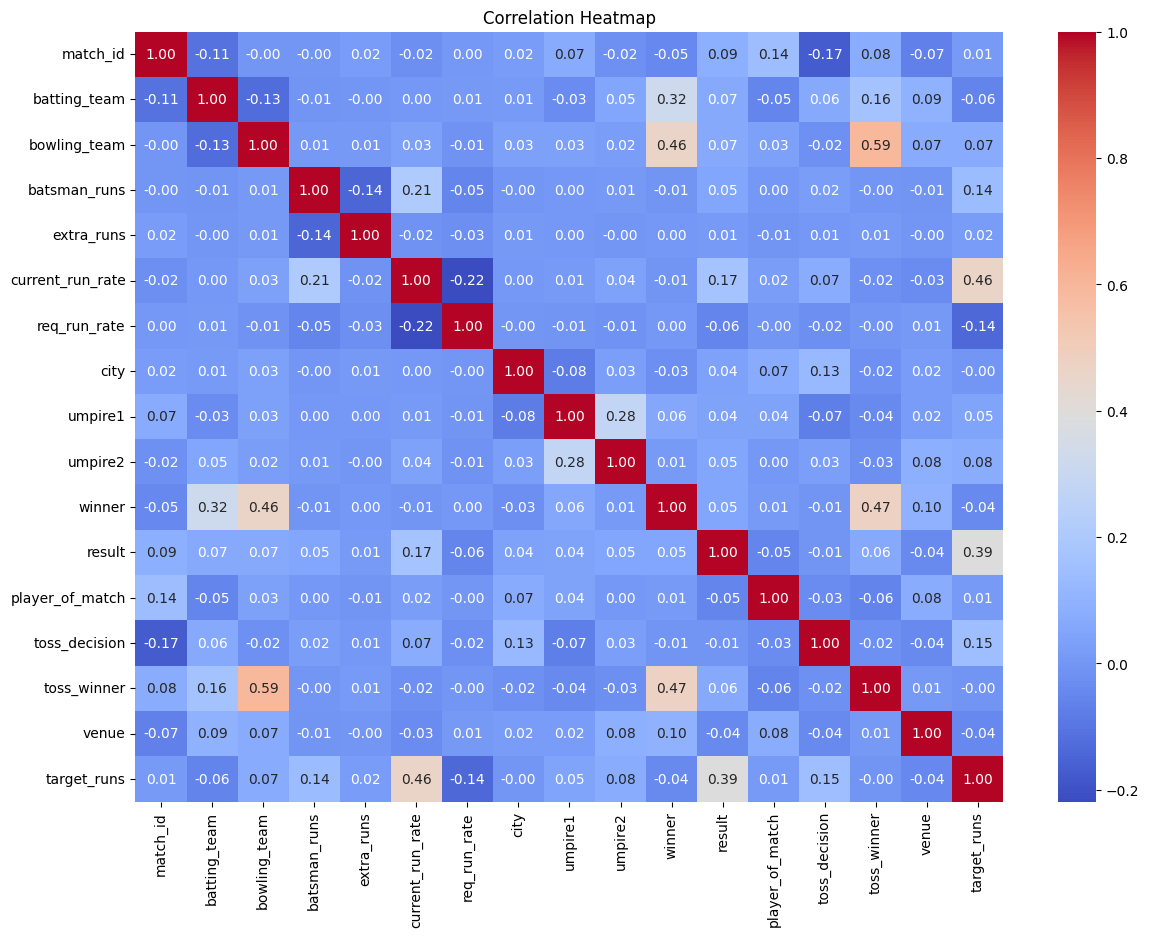

In [45]:
# creating correlation matrix
correlation_matrix = merged_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

- Keeping the correlated features for result 'batting_team', 'bowling_team',
'current_run_rate', 'req_run_rate', 'winner', 'toss_decision', 'toss_winner', 'venue', 'target_runs'

In [46]:
merged_df = merged_df[['batting_team', 'bowling_team', 'current_run_rate', 'req_run_rate', 'toss_decision', 'toss_winner', 'venue', 'winner','target_runs']]

## *MODEL DEVELOPMENT*

### Class Imbalance

Class imbalance occurs when the distribution of classes in the dataset is not uniform, i.e., one class has significantly more samples than the others. It can lead to biased models that perform poorly on minority classes.

In [47]:
merged_df.shape

(54262, 9)

- Since the number of features are limited, there is no need of dimensionality reduction.

In [48]:
merged_df.columns

Index(['batting_team', 'bowling_team', 'current_run_rate', 'req_run_rate',
       'toss_decision', 'toss_winner', 'venue', 'winner', 'target_runs'],
      dtype='object')

In [49]:
merged_df.isnull().sum()

batting_team        0
bowling_team        0
current_run_rate    0
req_run_rate        0
toss_decision       0
toss_winner         0
venue               0
winner              0
target_runs         0
dtype: int64

In [50]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54262 entries, 0 to 55368
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   batting_team      54262 non-null  int64  
 1   bowling_team      54262 non-null  int64  
 2   current_run_rate  54262 non-null  float64
 3   req_run_rate      54262 non-null  float64
 4   toss_decision     54262 non-null  int64  
 5   toss_winner       54262 non-null  int64  
 6   venue             54262 non-null  int64  
 7   winner            54262 non-null  int64  
 8   target_runs       54262 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 4.1 MB


- CHECKING FOR CLASS IMBALANCE

In [51]:
class_counts = merged_df['winner'].value_counts()
print(class_counts)

5    7371
0    6923
3    6503
7    6061
1    5787
8    5633
6    5434
9    5256
2    3197
4    2097
Name: winner, dtype: int64


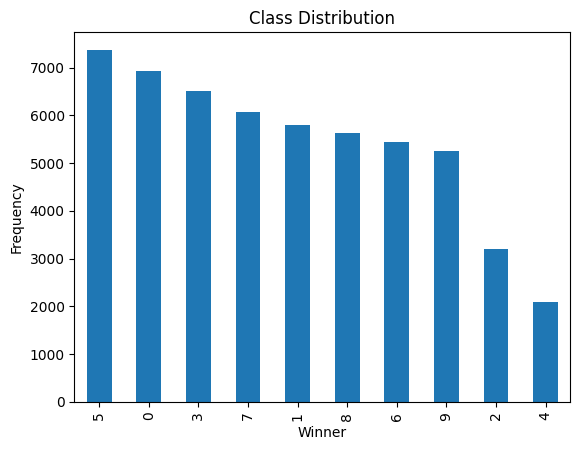

In [52]:
class_counts.plot(kind='bar')
plt.xlabel('Winner')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


In [53]:
imbalance_ratio = class_counts.min() / class_counts.max()
print("Class imbalance ratio:", imbalance_ratio)

Class imbalance ratio: 0.2844932844932845


- The distribution of the classes in the winner column, there is class imbalance in the dataset. The number of instances in each class varies significantly, with some classes having much fewer instances compared to others. For example, class 2 and class 4 have significantly fewer instances compared to classes like 5 and 0.

### SMOTE: Synthetic Minority Oversampling Technique
SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

< !pip install imbalanced-learn>

In [54]:
# Separate features and target variable
X = merged_df.drop(columns=['winner'])
y = merged_df['winner']

X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54262 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   batting_team      54262 non-null  int64  
 1   bowling_team      54262 non-null  int64  
 2   current_run_rate  54262 non-null  float64
 3   req_run_rate      54262 non-null  float64
 4   toss_decision     54262 non-null  int64  
 5   toss_winner       54262 non-null  int64  
 6   venue             54262 non-null  int64  
 7   target_runs       54262 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 3.7 MB
<class 'pandas.core.series.Series'>
Int64Index: 54262 entries, 0 to 55368
Series name: winner
Non-Null Count  Dtype
--------------  -----
54262 non-null  int64
dtypes: int64(1)
memory usage: 847.8 KB


In [55]:
# Initialize Smote
smote = SMOTE(random_state=42)

# Perform SMOTE after imputation
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
9    7371
3    7371
8    7371
5    7371
6    7371
1    7371
2    7371
0    7371
7    7371
4    7371
Name: winner, dtype: int64


### Logistic Regression

In [56]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression()

# Perform k-fold cross-validation
cv_scores = cross_val_score(log_reg_model, X_resampled, y_resampled, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
print("Mean accuracy:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores: [0.20139737 0.24684575 0.24114774 0.28069461 0.24277574]
Mean accuracy: 0.24257224257224258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN

In [57]:
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(knn_classifier, X_resampled, y_resampled, cv=5)

# Calculate accuracy
accuracy = accuracy_score(y_resampled, y_pred)

# Print accuracy
print("Accuracy:", "{:.4f}".format(accuracy))

# Print classification report
print("Classification Report:")
print(classification_report(y_resampled, y_pred))

Accuracy: 0.8365
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      7371
           1       0.79      0.93      0.86      7371
           2       0.86      0.98      0.92      7371
           3       0.82      0.83      0.82      7371
           4       0.89      0.99      0.93      7371
           5       0.63      0.20      0.31      7371
           6       0.79      0.94      0.86      7371
           7       0.78      0.87      0.82      7371
           8       0.89      0.92      0.90      7371
           9       0.94      0.94      0.94      7371

    accuracy                           0.84     73710
   macro avg       0.82      0.84      0.82     73710
weighted avg       0.82      0.84      0.82     73710



### GNB

In [58]:
# Initialize Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(gnb_classifier, X_resampled, y_resampled, cv=5)

# Calculate accuracy
accuracy = accuracy_score(y_resampled, y_pred)

# Print accuracy
print("Accuracy:", "{:.4f}".format(accuracy))

# Print classification report
print("Classification Report:")
print(classification_report(y_resampled, y_pred))


Accuracy: 0.2633
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.42      0.38      7371
           1       0.27      0.33      0.30      7371
           2       0.31      0.40      0.35      7371
           3       0.06      0.02      0.03      7371
           4       0.25      0.30      0.27      7371
           5       0.35      0.26      0.30      7371
           6       0.26      0.05      0.09      7371
           7       0.23      0.23      0.23      7371
           8       0.21      0.30      0.24      7371
           9       0.25      0.31      0.28      7371

    accuracy                           0.26     73710
   macro avg       0.25      0.26      0.25     73710
weighted avg       0.25      0.26      0.25     73710



### Decision Tree

In [59]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=8, min_samples_leaf=10)

# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(dt_model, X_resampled, y_resampled, cv=5)

# Calculate accuracy
accuracy = accuracy_score(y_resampled, y_pred)

# Print accuracy
print("Accuracy:", "{:.4f}".format(accuracy))

# Print classification report
print("Classification Report:")
print(classification_report(y_resampled, y_pred))

Accuracy: 0.9055
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.83      7371
           1       0.90      1.00      0.95      7371
           2       0.95      0.99      0.97      7371
           3       0.91      0.94      0.92      7371
           4       0.96      0.99      0.97      7371
           5       0.88      0.42      0.56      7371
           6       0.88      0.99      0.93      7371
           7       0.94      0.98      0.96      7371
           8       0.88      1.00      0.93      7371
           9       0.84      0.99      0.91      7371

    accuracy                           0.91     73710
   macro avg       0.91      0.91      0.90     73710
weighted avg       0.91      0.91      0.90     73710



### Random Forest

In [60]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(rf_model, X_resampled, y_resampled, cv=5)

# Calculate accuracy
accuracy = accuracy_score(y_resampled, y_pred)

# Print accuracy
print("Accuracy:", "{:.4f}".format(accuracy))

# Print classification report
print("Classification Report:")
print(classification_report(y_resampled, y_pred))

Accuracy: 0.9310
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      7371
           1       0.89      1.00      0.94      7371
           2       0.96      1.00      0.98      7371
           3       0.91      0.96      0.93      7371
           4       0.98      1.00      0.99      7371
           5       0.94      0.47      0.62      7371
           6       0.93      1.00      0.96      7371
           7       0.92      0.98      0.95      7371
           8       0.95      1.00      0.97      7371
           9       0.93      1.00      0.96      7371

    accuracy                           0.93     73710
   macro avg       0.93      0.93      0.92     73710
weighted avg       0.93      0.93      0.92     73710



### Models Comparisions

Platform: Linux-6.1.58+-x86_64-with-glibc2.35
CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
No GPUs detected.
RAM: 12.67 GB
KNN - Training Time: 0.1766 seconds, Testing Time: 6.7307 seconds
Decision Tree - Training Time: 0.2661 seconds, Testing Time: 0.0083 seconds
Random Forest - Training Time: 7.6337 seconds, Testing Time: 0.8552 seconds


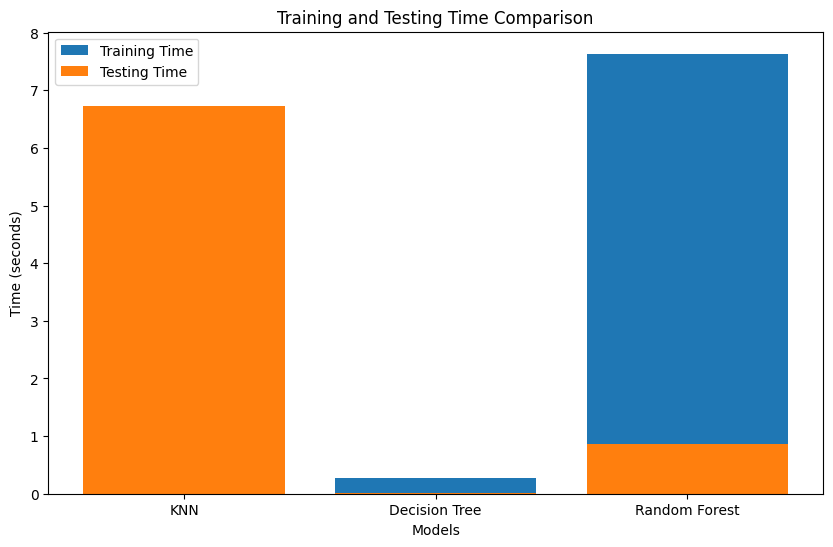

In [63]:
# Define functions to train and test each model
def train_model(model, X, y):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return training_time

def test_model(model, X):
    start_time = time.time()
    model.predict(X)
    end_time = time.time()
    testing_time = end_time - start_time
    return testing_time

# Initialize models
knn_classifier = KNeighborsClassifier(n_neighbors=5)
dt_model = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=8, min_samples_leaf=10)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Initialize lists to store training and testing times
training_times = []
testing_times = []

# Perform cross-validation for KNN
X_resampled_knn = X_resampled  # Assuming X_resampled is defined earlier
y_resampled_knn = y_resampled  # Assuming y_resampled is defined earlier
training_time_knn = train_model(knn_classifier, X_resampled_knn, y_resampled_knn)
testing_time_knn = test_model(knn_classifier, X_resampled_knn)
training_times.append(training_time_knn)
testing_times.append(testing_time_knn)

# Perform cross-validation for Decision Tree
X_resampled_dt = X_resampled  # Assuming X_resampled is defined earlier
y_resampled_dt = y_resampled  # Assuming y_resampled is defined earlier
training_time_dt = train_model(dt_model, X_resampled_dt, y_resampled_dt)
testing_time_dt = test_model(dt_model, X_resampled_dt)
training_times.append(training_time_dt)
testing_times.append(testing_time_dt)

# Perform cross-validation for Random Forest
X_resampled_rf = X_resampled  # Assuming X_resampled is defined earlier
y_resampled_rf = y_resampled  # Assuming y_resampled is defined earlier
training_time_rf = train_model(rf_model, X_resampled_rf, y_resampled_rf)
testing_time_rf = test_model(rf_model, X_resampled_rf)
training_times.append(training_time_rf)
testing_times.append(testing_time_rf)


# Print platform information
print("Platform:", platform.platform())

# Print CPU information
cpu_info = cpuinfo.get_cpu_info()
print("CPU:", cpu_info['brand_raw'])

# Print GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i+1} - Name: {gpu.name}, Memory Free: {gpu.memoryFree} MB, Memory Used: {gpu.memoryUsed} MB, Memory Total: {gpu.memoryTotal} MB")
else:
    print("No GPUs detected.")

# Print RAM information
ram_gb = psutil.virtual_memory().total / 1024**3
print("RAM:", round(ram_gb, 2), "GB")


# Print training and testing times
models = ['KNN', 'Decision Tree', 'Random Forest']
for i, model in enumerate(models):
    print(f"{model} - Training Time: {training_times[i]:.4f} seconds, Testing Time: {testing_times[i]:.4f} seconds")

# Plot comparison graph
models = ['KNN', 'Decision Tree', 'Random Forest']
plt.figure(figsize=(10, 6))
plt.bar(models, training_times, label='Training Time')
plt.bar(models, testing_times, label='Testing Time')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Training and Testing Time Comparison')
plt.legend()
plt.show()

In [66]:
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(knn_classifier, X_resampled, y_resampled, cv=5)
# Calculate accuracy
p1 = accuracy_score(y_resampled, y_pred)
f1 = f1_score(y_resampled, y_pred, average='weighted')  # Use weighted average for multi-class classification
# Print accuracy
print("Accuracy for KNN:", "{:.4f}".format(p1))
print("f1 score for KNN:", "{:.4f}".format(f1))

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=8, min_samples_leaf=10)
# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(dt_model, X_resampled, y_resampled, cv=5)
# Calculate accuracy
p2 = accuracy_score(y_resampled, y_pred)
f2 = f1_score(y_resampled, y_pred, average='weighted')  # Use weighted average for multi-class classification
# Print accuracy
print("Accuracy for Decision Tree:", "{:.4f}".format(p2))
print("f1 score for Decision Tree:", "{:.4f}".format(f2))

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# Perform cross-validation and obtain predicted labels
y_pred = cross_val_predict(rf_model, X_resampled, y_resampled, cv=5)
# Calculate accuracy
p3 = accuracy_score(y_resampled, y_pred)
f3 = f1_score(y_resampled, y_pred, average='weighted')  # Use weighted average for multi-class classification
# Print accuracy
print("Accuracy for Random Forest:", "{:.4f}".format(p3))
print("f1 score for Random Forest:", "{:.4f}".format(f3))


Accuracy for KNN: 0.8365
f1 score for KNN: 0.8168
Accuracy for Decision Tree: 0.9055
f1 score for Decision Tree: 0.8950
Accuracy for Random Forest: 0.9310
f1 score for Random Forest: 0.9226


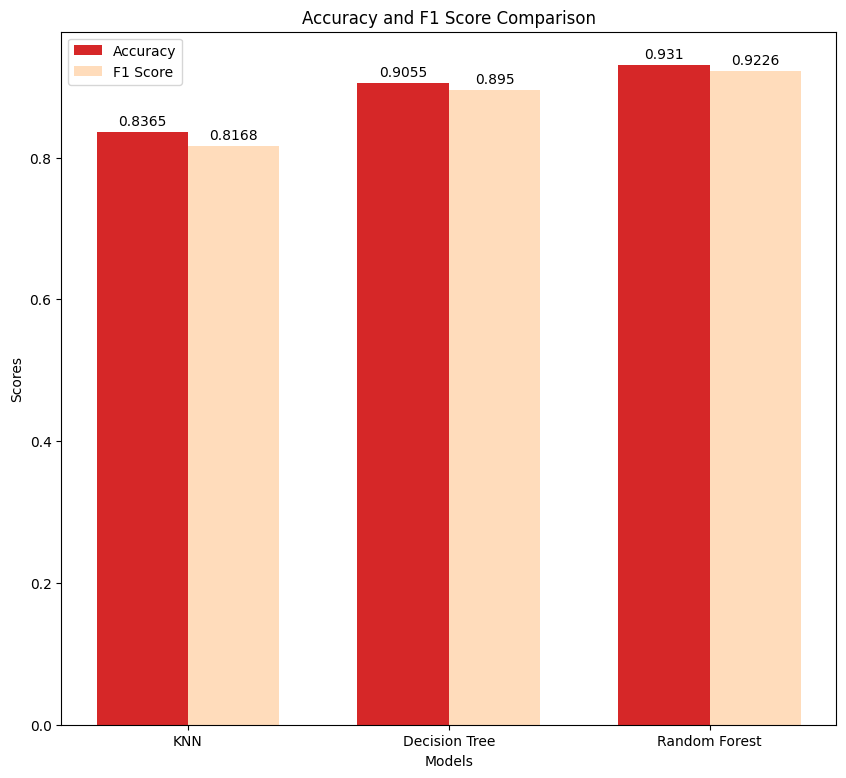

In [86]:
# Define data
models = ['KNN', 'Decision Tree', 'Random Forest']
accuracy_scores = [p1, p2, p3]
f1_scores = [f1, f2, f3]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 9))

# Plot accuracy scores
plt.bar(r1, accuracy_scores, color = '#d62728', width=bar_width,  label='Accuracy')

# Plot F1 scores
plt.bar(r2, f1_scores, color = '#ffbb78',width=bar_width, alpha=0.5, label='F1 Score')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and F1 Score Comparison')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend()

# Add value labels on bars
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.005, str(round(v, 4)), ha='center', va='bottom', fontsize=10)

for i, v in enumerate(f1_scores):
    plt.text(i + bar_width, v + 0.005, str(round(v, 4)), ha='center', va='bottom', fontsize=10)

plt.show()